# Scenario 3 subtask 1: Estimate the True Number of Infections

**Background:** 10/2020 - 1/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

## **TASK 1:** Replicate the fitting exercise (A) in Section 3.2 <br>
paper: https://doi.org/10.1016/j.scitotenv.2022.159326.

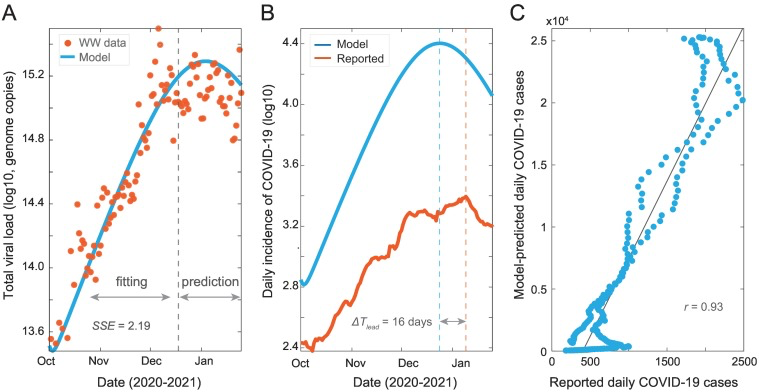

**Specifications:**
1. SEIR-V model
2. Fit $\lambda$, $\alpha$, and E(0).
3. Data found in supplementary materials
4. Simplify wherever necessary (e.g. fixed $\beta$)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests

### Plot the Data:

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


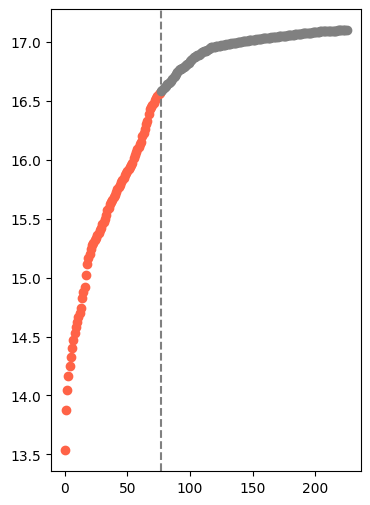

In [2]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

### Simulate using the best fit parameters

$\beta = 4.49\times 10^7$ viral RNA per g.

Best fit parameters: $\lambda =9.66\times 10^{-8}\frac{1}{day\cdot person}, \alpha = 249 g, \gamma = 0.08, \text{ and } E(0) = 11 \text{ people.}$



In [33]:
from mira.sources.askenet import model_from_json_file


best_fit_model = model_from_json_file('ES3_detection_log10V.json')
best_fit_model.initials['E'].value = 11
S, E, I = best_fit_model.initials['S'].value, best_fit_model.initials['E'].value, best_fit_model.initials['I'].value

best_fit_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
#best_fit_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
best_fit_model.parameters['gamma'].value = 0.08
best_fit_model.parameters['beta'].value = 44852600
best_fit_model.parameters['delta'].value = 0.125

best_fit_model.parameters['k'].value = 0.333
#best_fit_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

best_fit_model.parameters['alpha'].value = 249 
best_fit_model.parameters['alpha'].distribution = None#Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [17]:
best_fit_model.parameters

{'lambda': Parameter(name='lambda', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/(day*person)), value=0.2221810626, distribution=None),
 'k': Parameter(name='k', display_name=None, description=None, identifiers={}, context={}, units=None, value=0.333, distribution=None),
 'delta': Parameter(name='delta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1/day), value=0.125, distribution=None),
 'alpha': Parameter(name='alpha', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=gram), value=249, distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})),
 'beta': Parameter(name='beta', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=virus/gram), value=44852600, distribution=None),
 'gamma': Parameter(name='gamma', display_name=None, description=None, identifiers={}, context={}, units=Unit(expression=1

In [18]:
num_samples = 1
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time) + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        best_fit_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
prior_samples['data']

,timepoint_id,sample_id,alpha_param,lambda_param,k_param,delta_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,4.069259e-21,1.355063e-21,11.000000,3.663000e-10,2.300000e+06,2.714195e-21,3.424865e+13,13.534644,0.0
1,1,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,3.522258e-01,1.172912e-01,8.199423,2.954639e+00,2.300000e+06,2.349346e-01,3.425447e+13,13.534718,1.0
2,2,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,1.238898e+00,4.125530e-01,6.641379,4.900506e+00,2.299999e+06,8.263450e-01,3.426915e+13,13.534904,2.0
3,3,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,2.486715e+00,8.280761e-01,5.828737,6.258935e+00,2.299998e+06,1.658639e+00,3.428980e+13,13.535165,3.0
4,4,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,3.995460e+00,1.330488e+00,5.466444,7.281140e+00,2.299996e+06,2.664968e+00,3.431476e+13,13.535481,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,222,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,2.283182e+06,7.602996e+05,14906.362305,1.128313e+05,1.681814e+04,1.522882e+06,6.344327e+16,16.802386,222.0
223,223,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,2.285877e+06,7.611981e+05,12968.909180,1.039242e+05,1.412038e+04,1.524682e+06,6.384162e+16,16.805104,223.0
224,224,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,2.288177e+06,7.619636e+05,11241.350586,9.549105e+04,1.182254e+04,1.526214e+06,6.420810e+16,16.807590,224.0
225,225,0,89.114128,0.222181,0.333,0.125,44852600.0,0.08,2.290128e+06,7.626124e+05,9708.579102,8.753969e+04,9.872359e+03,1.527515e+06,6.454452e+16,16.809860,225.0


## **TASK 2:** Plot the uncalibrated trajectories

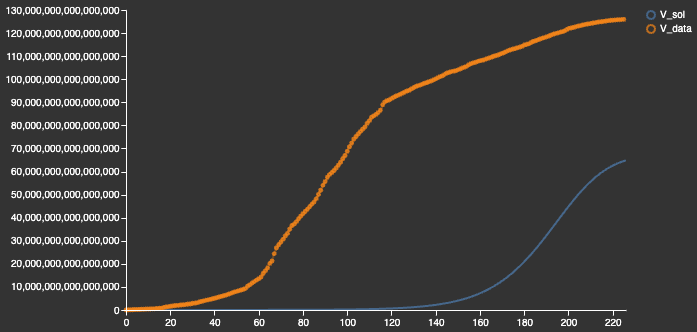

In [19]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), 
                            keep=["V_sol"],
                            #markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema,format='interactive')

### Calibrate:

In [34]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
    best_fit_model,
    './data/processed_dataset_train.csv',
    5,
    timepoints=timepoints,
    num_iterations=2,
    visual_options={"title": "3_base", "keep":["V_sol"]},
    time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=1.0000081062316895, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=2.0000078678131104, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=3.0000088214874268, observation={'V': tensor(1.4551e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Obse

RuntimeError: AutoLowRankMultivariateNormal found no latent variables; Use an empty guide instead
Trace Shapes:
 Param Sites:
Sample Sites:

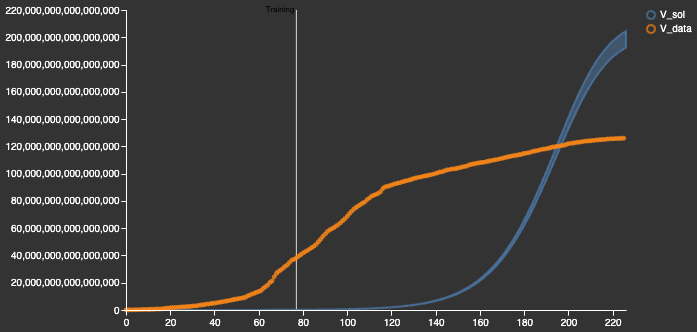

In [23]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), 
                            keep=["V_sol"],
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"})
                           )
schema = plots.pad(schema, 5)
plots.ipy_display(schema,format='interactive')

### Mimic The Paper Figure

In [ ]:
# TODO when data we're training on actually matches

In [ ]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]),
                            keep="V_sol",
                           # markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## **TASK 3:** Repeat with uncertainty over the paper's parameters.

In [24]:
#SEIV_model_url  = "https://raw.githubusercontent.com/indralab/mira/hackathon2/notebooks/evaluation_2023.07/eval_scenario3_base.json"
from mira.sources.askenet import model_from_json_file
SEIVCDU_model_json = 'ES3_detection_log10V.json'
uncertain_model = model_from_json_file('ES3_detection_log10V.json')
uncertain_model.initials['E'].value = 1000
S, E, I = uncertain_model.initials['S'].value, uncertain_model.initials['E'].value, uncertain_model.initials['I'].value

uncertain_model.parameters['lambda'].value = 9.66e-8*(S + E + I)
uncertain_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.1, "maximum":0.21})
uncertain_model.parameters['gamma'].value = 0.08
uncertain_model.parameters['gamma'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.05, "maximum":0.15})
uncertain_model.parameters['beta'].value = 44852600
uncertain_model.parameters['delta'].value = 0.125

uncertain_model.parameters['k'].value = 0.333
uncertain_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

uncertain_model.parameters['alpha'].value = 249 
uncertain_model.parameters['alpha'].distribution = distribution=Distribution(type='Uniform1', parameters={'minimum': 50.0, 'maximum': 400.0})

In [27]:
num_samples = 100
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time) + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())

prior_samples = load_and_sample_petri_model(
        uncertain_model, num_samples, timepoints=timepoints,
    visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

In [28]:
prior_samples['data']

,timepoint_id,sample_id,lambda_param,k_param,alpha_param,gamma_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,0.150917,0.380041,303.765930,0.136408,0.125,44852600.0,2.866498e-19,1.089387e-19,1000.000000,3.800412e-08,2300000.00,1.777110e-19,3.424865e+13,13.534644,0.0
1,1,0,0.150917,0.380041,303.765930,0.136408,0.125,44852600.0,2.441108e+01,9.277214e+00,705.317688,2.988658e+02,2299975.50,1.513386e+01,3.615268e+13,13.558141,1.0
2,2,0,0.150917,0.380041,303.765930,0.136408,0.125,44852600.0,8.437854e+01,3.206733e+01,532.927246,4.815327e+02,2299915.50,5.231121e+01,4.083005e+13,13.610980,2.0
3,3,0,0.150917,0.380041,303.765930,0.136408,0.125,44852600.0,1.662661e+02,6.318798e+01,433.006592,5.954857e+02,2299833.50,1.030781e+02,4.721721e+13,13.674101,3.0
4,4,0,0.150917,0.380041,303.765930,0.136408,0.125,44852600.0,2.620137e+02,9.957594e+01,376.048370,6.688504e+02,2299735.75,1.624377e+02,5.468557e+13,13.737873,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22695,222,99,0.117657,0.467981,225.093277,0.091586,0.125,44852600.0,1.157688e+04,5.417756e+03,55.608479,2.184378e+02,2288422.25,6.159127e+03,9.369193e+14,14.971703,222.0
22696,223,99,0.117657,0.467981,225.093277,0.091586,0.125,44852600.0,1.160251e+04,5.429746e+03,55.283382,2.171608e+02,2288396.25,6.172755e+03,9.389170e+14,14.972628,223.0
22697,224,99,0.117657,0.467981,225.093277,0.091586,0.125,44852600.0,1.162798e+04,5.441665e+03,54.960209,2.158913e+02,2288370.00,6.186299e+03,9.409032e+14,14.973545,224.0
22698,225,99,0.117657,0.467981,225.093277,0.091586,0.125,44852600.0,1.165330e+04,5.453520e+03,54.638771,2.146283e+02,2288346.25,6.199785e+03,9.428767e+14,14.974455,225.0


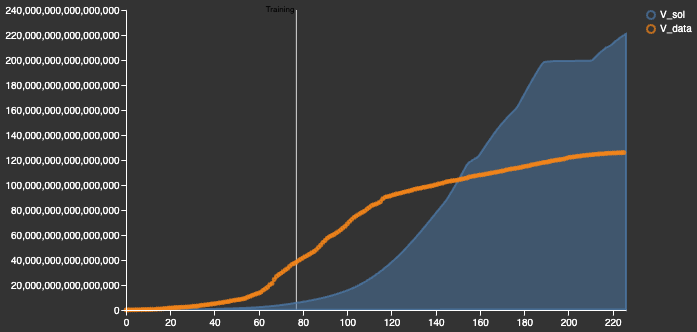

In [29]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]),
                            keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema, format='interactive')

### Calibrate:

In [30]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
    uncertain_model,
    './data/processed_dataset_train.csv',
    5,
    timepoints=timepoints,
    num_iterations=2,
    visual_options={"title": "3_base", "keep":["V_sol"]},
    time_unit="days")

/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=1.0000063180923462, observation={'V': tensor(7.4826e+13)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=2.000009298324585, observation={'V': tensor(1.1077e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/krue284/Local Files/283-scen3/src/pyciemss/PetriNetODE/interfaces.py:874: UserWarning: Observation ObservationEvent(time=3.0000054836273193, observation={'V': tensor(1.4551e+14)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Obser

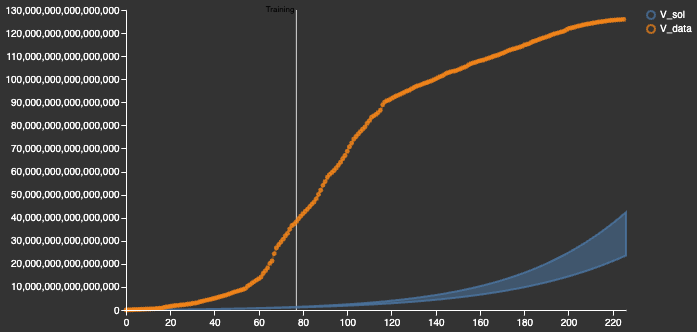

In [31]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]),
                            keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema, format='interactive')

In [32]:
# View what values the calibration landed on
display(calibrated_samples["data"])

,timepoint_id,sample_id,lambda_param,k_param,alpha_param,gamma_param,delta_param,beta_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
0,0,0,0.155528,0.381185,207.683212,0.078683,0.125,44852600.0,2.962965e-19,1.129437e-19,1000.000000,3.811847e-08,2300000.000,1.833529e-19,3.424865e+13,13.534644,0.0
1,1,0,0.155528,0.381185,207.683212,0.078683,0.125,44852600.0,2.522740e+01,9.616297e+00,705.246338,2.996970e+02,2299975.000,1.561110e+01,3.564131e+13,13.551954,1.0
2,2,0,0.155528,0.381185,207.683212,0.078683,0.125,44852600.0,8.721024e+01,3.324323e+01,534.002991,4.830843e+02,2299913.250,5.396702e+01,3.906313e+13,13.591767,2.0
3,3,0,0.155528,0.381185,207.683212,0.078683,0.125,44852600.0,1.719138e+02,6.553088e+01,435.648468,5.980342e+02,2299825.000,1.063828e+02,4.373915e+13,13.640871,3.0
4,4,0,0.155528,0.381185,207.683212,0.078683,0.125,44852600.0,2.710849e+02,1.033334e+02,380.333862,6.727792e+02,2299729.000,1.677515e+02,4.921403e+13,13.692089,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,222,4,0.151159,0.386082,205.857056,0.078822,0.125,44852600.0,3.450834e+05,1.332306e+05,15166.076172,4.148555e+04,1954916.875,2.118528e+05,1.972822e+16,16.295088,222.0
1131,223,4,0.151159,0.386082,205.857056,0.078822,0.125,44852600.0,3.512253e+05,1.356019e+05,15406.454102,4.215949e+04,1948776.875,2.156235e+05,2.008390e+16,16.302849,223.0
1132,224,4,0.151159,0.386082,205.857056,0.078822,0.125,44852600.0,3.574637e+05,1.380104e+05,15649.644531,4.284200e+04,1942536.375,2.194532e+05,2.044541e+16,16.310596,224.0
1133,225,4,0.151159,0.386082,205.857056,0.078822,0.125,44852600.0,3.637995e+05,1.404564e+05,15895.663086,4.353308e+04,1936201.250,2.233426e+05,2.081275e+16,16.318330,225.0


In [15]:
calibrated_samples['data'].to_csv('data/calibrated_samples_from_wastewater.csv', index=False)

**BONUS:** Use temperature data during fitting to replicate figure 3A. Prove that it improves fit.
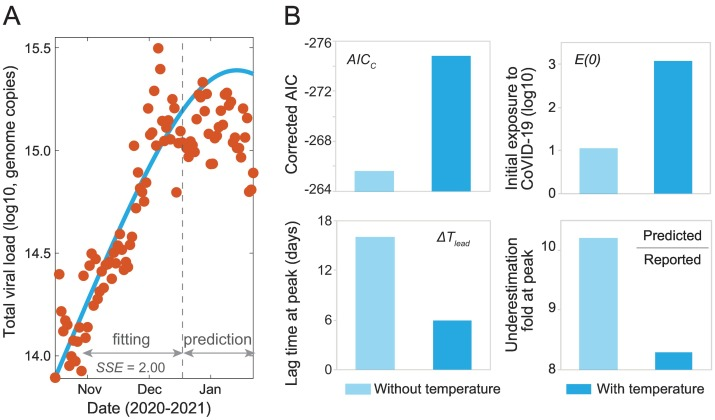

In [16]:
# TODO